In [9]:
import os, json, time, random
from pathlib import Path
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from tqdm.auto import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

BASE = r"C:\Users\Raj Dhanush\OneDrive\Desktop\DEEPLEARNING PROJECT"
TRAIN_AUDIO_DIR = os.path.join(BASE, "depression_detection", "data", "train")
TEST_AUDIO_DIR  = os.path.join(BASE, "depression_detection", "data", "test")
TRAIN_CSV = os.path.join(BASE, "train_split_Depression_AVEC2017.csv")
FEATURE_DIR = os.path.join(BASE, "depression_detection", "features")
MODEL_DIR = os.path.join(BASE, "depression_detection", "models")
os.makedirs(FEATURE_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)


DEVICE: cpu


In [11]:
SR = 16000
WINDOW_SEC = 5.0
HOP_SEC = 2.5
N_MELS = 64
N_FFT = 1024
HOP_LEN = 256

BATCH_SIZE = 16
EPOCHS = 15
PATIENCE = 6
SEED = 42

def set_seed(s=SEED):
    random.seed(s); np.random.seed(s); torch.manual_seed(s)
set_seed()

def extract_log_mel(y, sr=SR, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LEN):
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, power=2.0)
    log_mel = librosa.power_to_db(mel, ref=np.max)
    return log_mel.astype(np.float32)


In [12]:
def process_file_to_windows(wav_path, out_dir, window_sec=WINDOW_SEC, hop_sec=HOP_SEC, sr=SR):
    y, _ = librosa.load(wav_path, sr=sr)
    total = len(y)
    window_samples = int(window_sec * sr)
    hop_samples = int(hop_sec * sr)
    starts = list(range(0, max(1, total - window_samples + 1), hop_samples))
    if starts and (starts[-1] + window_samples < total):
        starts.append(total - window_samples)
    if not starts:
        starts = [0]
    saved = []
    for i, s in enumerate(starts):
        chunk = y[s:s+window_samples]
        mel = extract_log_mel(chunk, sr=sr)
        base = Path(wav_path).stem
        fname = f"{base}_win{i}.npy"
        out_path = os.path.join(out_dir, fname)
        np.save(out_path, mel)
        saved.append(out_path)
    return saved

def preprocess_all_train(train_csv=TRAIN_CSV, audio_dir=TRAIN_AUDIO_DIR, feature_dir=FEATURE_DIR):
    df = pd.read_csv(train_csv)
    mapping = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Preprocess train"):
        pid = str(int(row['Participant_ID']))
        wav_name = f"{pid}_AUDIO.wav"
        wav_path = os.path.join(audio_dir, wav_name)
        if not os.path.exists(wav_path):
            print("Missing:", wav_path)
            continue
        saved = process_file_to_windows(wav_path, feature_dir)
        for p in saved:
            mapping.append({"file": p, "participant": pid, "label": int(row["PHQ8_Binary"])})
    with open(os.path.join(feature_dir, "mapping.json"), "w") as f:
        json.dump(mapping, f)
    print("Total windows saved:", len(mapping))
    return mapping

mapping_path = os.path.join(FEATURE_DIR, "mapping.json")
if not os.path.exists(mapping_path):
    preprocess_all_train()
else:
    print("Mapping exists:", mapping_path)


Mapping exists: C:\Users\Raj Dhanush\OneDrive\Desktop\DEEPLEARNING PROJECT\depression_detection\features\mapping.json


In [13]:
with open(mapping_path, "r") as f:
    mapping = json.load(f)
print("Total windows:", len(mapping))
from collections import Counter
cnt = Counter([m["participant"] for m in mapping])
print("Example windows per participant (first 8):", list(cnt.items())[:8])


Total windows: 38682
Example windows per participant (first 8): [('303', 394), ('304', 317), ('305', 681), ('310', 337), ('312', 315), ('313', 301), ('315', 390), ('316', 347)]


In [14]:
class WindowDataset(Dataset):
    def __init__(self, mapping, max_frames=None):
        self.mapping = mapping
        self.max_frames = max_frames or self._compute_max_frames()
    def _compute_max_frames(self):
        maxf = 0
        for entry in self.mapping:
            arr = np.load(entry["file"])
            maxf = max(maxf, arr.shape[1])
        return maxf
    def __len__(self):
        return len(self.mapping)
    def __getitem__(self, idx):
        entry = self.mapping[idx]
        arr = np.load(entry["file"])
        n_mels, frames = arr.shape
        mf = self.max_frames
        if frames < mf:
            arr = np.pad(arr, ((0,0),(0,mf-frames)), mode='constant')
        elif frames > mf:
            arr = arr[:, :mf]
        x = torch.tensor(arr, dtype=torch.float).unsqueeze(0)
        y = torch.tensor(entry["label"], dtype=torch.float)
        return x, y

dataset = WindowDataset(mapping)
print("Dataset windows:", len(dataset), "max_frames:", dataset.max_frames)


Dataset windows: 38682 max_frames: 313


In [15]:
df_map = pd.DataFrame(mapping)
participants = df_map['participant'].unique()
part_labels = df_map.groupby('participant')['label'].first().astype(int)
train_parts, val_parts = train_test_split(participants, test_size=0.2, random_state=SEED, 
                                          stratify=[part_labels.get(p,0) for p in participants])

train_idx = df_map[df_map['participant'].isin(train_parts)].index.tolist()
val_idx   = df_map[df_map['participant'].isin(val_parts)].index.tolist()

train_ds = Subset(dataset, train_idx)
val_ds = Subset(dataset, val_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
print("Train windows:", len(train_ds), "Val windows:", len(val_ds))


Train windows: 30789 Val windows: 7893


In [16]:
class ConvEncoder(nn.Module):
    def __init__(self, in_ch=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, 16, kernel_size=3, padding=1), nn.BatchNorm2d(16), nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

class CNNBiLSTM(nn.Module):
    def __init__(self, n_mels=N_MELS, lstm_hidden=128, n_layers=1):
        super().__init__()
        self.encoder = ConvEncoder()
        self.lstm_hidden = lstm_hidden
        self.lstm = None
        self.classifier = nn.Sequential(
            nn.Linear(2*lstm_hidden, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        b,c,h,w = x.shape
        feat = self.encoder(x)
        b,c2,h2,w2 = feat.shape
        feat = feat.permute(0,3,1,2).contiguous().view(b, w2, -1)
        if self.lstm is None:
            input_size = feat.shape[-1]
            self.lstm = nn.LSTM(input_size=input_size, hidden_size=self.lstm_hidden,
                                num_layers=1, batch_first=True, bidirectional=True).to(DEVICE)
        out, _ = self.lstm(feat)
        out = out[:, -1, :]
        logits = self.classifier(out).squeeze(1)
        return logits

model = CNNBiLSTM().to(DEVICE)
print(model)


CNNBiLSTM(
  (encoder): ConvEncoder(
    (net): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_

In [17]:
# Use num_workers=0 for robust debug!
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

print("Testing first few batches for DataLoader...")
for i, (xb, yb) in enumerate(train_loader):
    print(f"Read batch {i}: x={xb.shape} y={yb.shape}")
    if i >= 2:
        break
print("Batch test done.")


Testing first few batches for DataLoader...
Read batch 0: x=torch.Size([16, 1, 64, 313]) y=torch.Size([16])
Read batch 1: x=torch.Size([16, 1, 64, 313]) y=torch.Size([16])
Read batch 2: x=torch.Size([16, 1, 64, 313]) y=torch.Size([16])
Batch test done.


In [18]:
# Updated DataLoader with num_workers=0
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

from tqdm.notebook import tqdm

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

best_val = float('inf')
pat = 0
for epoch in range(1, EPOCHS+1):
    print(f"\nEpoch {epoch}/{EPOCHS}", flush=True)
    model.train()
    train_loss = 0.0
    for xb, yb in tqdm(train_loader, desc=f"Train E{epoch}"):
        xb = xb.to(DEVICE); yb = yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(DEVICE); yb = yb.to(DEVICE)
            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item() * xb.size(0)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds.extend(probs.tolist())
            trues.extend(yb.cpu().numpy().tolist())
    val_loss /= len(val_loader.dataset)
    val_pred = [1 if p>0.5 else 0 for p in preds]
    val_acc = accuracy_score(trues, val_pred)
    val_f1 = f1_score(trues, val_pred, zero_division=0)
    print(f"Epoch {epoch}: train_loss={train_loss:.4f} val_loss={val_loss:.4f} acc={val_acc:.4f} f1={val_f1:.4f}")

    if val_loss < best_val:
        best_val = val_loss
        pat = 0
        torch.save(model.state_dict(), os.path.join(MODEL_DIR, "best_cnn_bilstm.pth"))
        print("Saved best model.")
    else:
        pat += 1
        if pat >= PATIENCE:
            print("Early stopping")
            break
print("Training completed.")



Epoch 1/15


Train E1:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 1: train_loss=0.5834 val_loss=0.5781 acc=0.7158 f1=0.0508
Saved best model.

Epoch 2/15


Train E2:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 2: train_loss=0.5428 val_loss=0.5804 acc=0.7317 f1=0.1803

Epoch 3/15


Train E3:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 3: train_loss=0.4666 val_loss=0.6638 acc=0.7087 f1=0.2405

Epoch 4/15


Train E4:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 4: train_loss=0.4012 val_loss=0.7539 acc=0.6607 f1=0.2224

Epoch 5/15


Train E5:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 5: train_loss=0.3564 val_loss=0.7884 acc=0.6835 f1=0.2337

Epoch 6/15


Train E6:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 6: train_loss=0.3202 val_loss=0.9958 acc=0.5808 f1=0.1815

Epoch 7/15


Train E7:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 7: train_loss=0.2956 val_loss=0.9853 acc=0.6278 f1=0.1929
Early stopping
Training completed.


In [29]:
import torch
import os

# Define model directory
MODEL_DIR = r"C:\Users\Raj Dhanush\OneDrive\Desktop\DEEPLEARNING PROJECT\depression_detection\models"
os.makedirs(MODEL_DIR, exist_ok=True)

# Save model weights
MODEL_PATH = os.path.join(MODEL_DIR, "logmel_cnn_bilstm.pth")
torch.save(model.state_dict(), MODEL_PATH)

print(f"✅ Model saved successfully at: {MODEL_PATH}")


✅ Model saved successfully at: C:\Users\Raj Dhanush\OneDrive\Desktop\DEEPLEARNING PROJECT\depression_detection\models\logmel_cnn_bilstm.pth


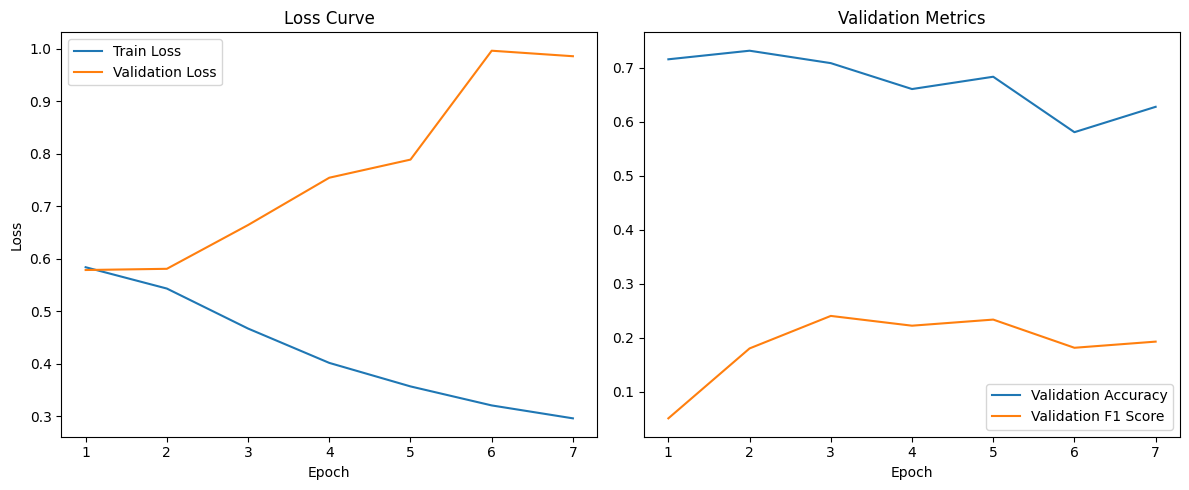

In [22]:
import matplotlib.pyplot as plt

# Manually entered recorded metrics from your training log
train_losses = [0.5834, 0.5428, 0.4666, 0.4012, 0.3564, 0.3202, 0.2956]
val_losses = [0.5781, 0.5804, 0.6638, 0.7539, 0.7884, 0.9958, 0.9853]
val_accuracies = [0.7158, 0.7317, 0.7087, 0.6607, 0.6835, 0.5808, 0.6278]
val_f1s = [0.0508, 0.1803, 0.2405, 0.2224, 0.2337, 0.1815, 0.1929]

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.plot(epochs, val_f1s, label='Validation F1 Score')
plt.xlabel('Epoch')
plt.title('Validation Metrics')
plt.legend()

plt.tight_layout()
plt.show()


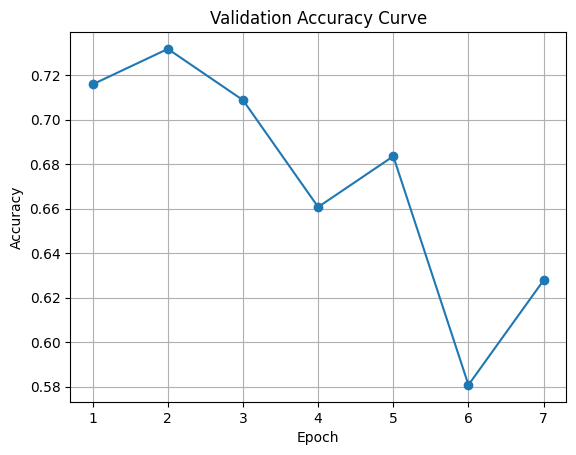

In [23]:
plt.plot(epochs, val_accuracies, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Curve')
plt.grid(True)
plt.show()
